<div class="alert alert-success">
<b>Reviewer's comment V2</b>
	  
Thanks for taking the time to improve the project! It's accepted now. Good luck on the next sprint! 
	  
</div>

**Review**
	  
Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a pretty good job overall, although there are a couple of problems that need to be fixed before the project can be accepted. Good luck!

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Libraries

In [1]:
!pip install -q --user --upgrade pandas seaborn sklearn scikit-learn category_encoders lightgbm xgboost catboost

In [2]:
import os, warnings
from IPython.display import display, Markdown
from pprint import pprint

from time import perf_counter as timer
from datetime import timedelta

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from category_encoders import BinaryEncoder

# from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [3]:
random_state = 42

In [4]:
def ignore_warnings(func):
    
    def wrap(*args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            return func(*args, **kwargs)
        
    return wrap

## Data preparation
***

### Features:
    DateCrawled — date profile was downloaded from the database
    VehicleType — vehicle body type
    RegistrationYear — vehicle registration year
    Gearbox — gearbox type
    Power — power (hp)
    Model — vehicle model
    Mileage — mileage (measured in km due to dataset's regional specifics)
    RegistrationMonth — vehicle registration month
    FuelType — fuel type
    Brand — vehicle brand
    NotRepaired — vehicle repaired or not
    DateCreated — date of profile creation
    NumberOfPictures — number of vehicle pictures
    PostalCode — postal code of profile owner (user)
    LastSeen — date of the last activity of the user
    
### Target:
    Price — price (Euro)

In [5]:
def find_file(filename):
    """Returns file path under /datasets directory, if exists, otherwise uses local dir"""
    
    filepath = f'/datasets/{filename}'
    if not os.path.isfile(filepath):
        filepath = filename
        
    return filepath

# find_file(filename)

In [6]:
filename = 'car_data.csv'

In [7]:
filename = find_file(filename)

In [8]:
!du -h "$filename"
!wc -l "$filename"
!head -n2 "$filename"

 39M	car_data.csv
  354370 car_data.csv
DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
24/03/2016 11:52,480,,1993,manual,0,golf,150000,0,petrol,volkswagen,,24/03/2016 00:00,0,70435,07/04/2016 03:16


39mb csv file, ~354k entries.

In [9]:
%%time
df = pd.read_csv(filename)

CPU times: user 488 ms, sys: 50.7 ms, total: 538 ms
Wall time: 538 ms


In [10]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [11]:
df.drop(['DateCrawled', 'LastSeen', 'PostalCode', 'DateCreated'], axis=1, inplace=True)

In [12]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Mileage            354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        283215 non-null  object
 11  NumberOfPictures   354369 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 137.3 MB


High memory usage, can optimize by downcasting types.

In [13]:
int_subset = df.select_dtypes('integer')
int_subset.dtypes

Price                int64
RegistrationYear     int64
Power                int64
Mileage              int64
RegistrationMonth    int64
NumberOfPictures     int64
dtype: object

In [14]:
df[int_subset.columns] = int_subset.apply(pd.to_numeric, downcast='integer')
df.select_dtypes('integer').dtypes

Price                int16
RegistrationYear     int16
Power                int16
Mileage              int32
RegistrationMonth     int8
NumberOfPictures      int8
dtype: object

In [15]:
del int_subset

In [16]:
df.info(memory_usage='deep', verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Columns: 12 entries, Price to NumberOfPictures
dtypes: int16(3), int32(1), int8(2), object(6)
memory usage: 125.1 MB


In [17]:
# df.select_dtypes('O')

In [18]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0


In [19]:
df.drop('NumberOfPictures', axis=1, inplace=True)

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Great, the data was loaded and inspected. You also dropped a constant feature, well done!
	  
</div>

## EDA

In [20]:
def rows_ratio(row_count, point=2):
    print('{:,} / {:,} ({}%)'.format(row_count, df.shape[0], (row_count/df.shape[0]*100).round(point)))

### RegistrationYear

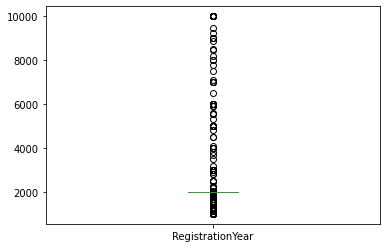

In [21]:
df['RegistrationYear'].plot.box();

In [22]:
np.array(sorted(df['RegistrationYear'].unique()))

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [23]:
reg_year_outliers = ((df['RegistrationYear'] < 1900) | (df['RegistrationYear'] > 2021))
rows_ratio(reg_year_outliers.sum())

171 / 354,369 (0.05%)


In [24]:
df[reg_year_outliers]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
622,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN
12946,49,NaN,5000,NaN,0,golf,5000,12,NaN,volkswagen,NaN
15147,0,NaN,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN
15870,1700,NaN,3200,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN
16062,190,NaN,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN
...,...,...,...,...,...,...,...,...,...,...,...
340548,0,NaN,3500,manual,75,NaN,5000,3,petrol,sonstige_autos,NaN
340759,700,NaN,1600,manual,1600,a3,150000,4,petrol,audi,no
341791,1,NaN,3000,NaN,0,zafira,5000,0,NaN,opel,NaN
348830,1,NaN,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN


Besides having an invalid RegistrationYear,  
some these observations also have invalid data in other features (Price, VehicleType, Gearbox, Power, etc..).  
Since it represents a very small fraction of all observations (0.05%), can safely drop them.

In [25]:
df.drop(df[reg_year_outliers].index, inplace=True)

In [26]:
np.array(sorted(df['RegistrationYear'].unique()))

array([1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype=int16)

### RegistrationMonth

In [27]:
df['RegistrationMonth'].describe()

count    354198.000000
mean          5.716819
std           3.725539
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

In [28]:
rows_ratio((df['RegistrationMonth'] == 0).sum())

37,220 / 354,198 (10.51%)


In [29]:
df['RegistrationMonth'].replace(0, np.NaN, inplace=True)

### NotRepaired

In [30]:
df['Repaired'] = df['NotRepaired'].map({'yes': 0, 'no': 1})
df.drop('NotRepaired', axis=1, inplace=True)

### Price

In [31]:
df['Price'].describe()

count    354198.000000
mean       4417.651314
std        4514.081022
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

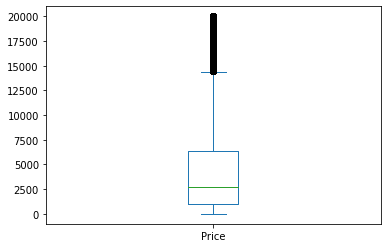

In [32]:
df['Price'].plot.box();

In [33]:
df[df['Price'] >= df['Price'].quantile(.99)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,Repaired
172,19750,convertible,2006,manual,305,mustang,50000,7.0,petrol,ford,1.0
337,18880,bus,2014,manual,116,5_reihe,20000,11.0,gasoline,mazda,1.0
484,19900,bus,2009,manual,150,viano,90000,5.0,gasoline,mercedes_benz,1.0
1360,19850,sedan,2013,auto,150,golf,60000,6.0,gasoline,volkswagen,1.0
1515,20000,sedan,2010,auto,239,a6,150000,5.0,gasoline,audi,1.0
...,...,...,...,...,...,...,...,...,...,...,...
353193,19500,bus,1970,auto,69,transporter,30000,11.0,petrol,volkswagen,NaN
353590,19950,wagon,2009,manual,265,other,125000,1.0,petrol,audi,1.0
354045,20000,coupe,2006,auto,476,other,125000,7.0,petrol,mercedes_benz,1.0
354178,19990,small,2014,auto,185,a1,10000,2.0,petrol,audi,1.0


Suspected upper outlier prices seem normal for the combination of features chosen (type, brand, model).

In [34]:
df.loc[(df['Price'] > 10) & (df['Price'] < 100) & (df['RegistrationYear'] > 2000)].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,Repaired
1076,45,NaN,2015,NaN,0,other,5000,NaN,NaN,mini,NaN
1459,30,NaN,2015,NaN,0,NaN,5000,NaN,NaN,seat,NaN
1788,80,NaN,2016,NaN,0,fiesta,5000,NaN,NaN,ford,0.0
2503,99,NaN,2008,NaN,0,NaN,20000,NaN,NaN,sonstige_autos,NaN
2687,90,small,2001,manual,0,twingo,150000,NaN,petrol,renault,0.0


Price doesn't make sense for the selected vehicles' years. Treating data as erroneous.

In [35]:
price_outliers = df[df['Price'] <= df['Price'].quantile(.05)]
price_outliers.shape[0]

19377

In [36]:
round(price_outliers.shape[0] / df.shape[0] * 100, 2)

5.47

Price selected outliers make up 5.47% of the dataframe, dropping.

In [37]:
df.drop(price_outliers.index, inplace=True)

### Power

In [38]:
df['Power'].describe()

count    334821.000000
mean        112.413295
std         187.138288
min           0.000000
25%          72.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

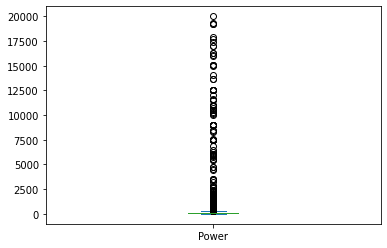

In [39]:
df['Power'].plot.box();

In [40]:
df[df['Power'] > 2000]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,Repaired
7661,1499,small,1999,manual,7515,lupo,150000,4.0,petrol,volkswagen,NaN
19092,9750,wagon,2005,auto,2729,5er,150000,7.0,gasoline,bmw,1.0
25232,10900,bus,2009,manual,10520,caddy,150000,6.0,gasoline,volkswagen,1.0
33952,3740,small,2006,manual,6920,aygo,90000,10.0,NaN,toyota,1.0
36206,5400,NaN,2017,manual,2017,transporter,150000,8.0,gasoline,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...,...
346639,1300,sedan,2000,manual,12512,carisma,150000,9.0,petrol,mitsubishi,NaN
346690,7498,NaN,2017,auto,2018,5er,150000,9.0,NaN,bmw,1.0
348137,850,sedan,1993,auto,9012,golf,150000,NaN,petrol,volkswagen,NaN
348237,3000,coupe,2007,manual,2007,corsa,150000,3.0,gasoline,opel,0.0


Supercars have horse power (hp) in the range of 1000 - 2000,  
anything above that (particulary for the above models) should be considered as an error.

In [41]:
df.loc[df['Power'] > 500, 'Power'] = np.NaN

In [42]:
power_outliers = df[df['Power'] < 30]

In [43]:
round(power_outliers.shape[0] / df.shape[0] * 100, 2)

10.09

In [44]:
df.loc[power_outliers.index, 'Power'] = np.NaN

### Duplicated entries

In [45]:
def dup_report(df):
    
    dup_count = df.duplicated().sum()
    
    print('duplicated rows: {:,} / {:,} ({:.1%})'.format(dup_count, df.shape[0], dup_count / df.shape[0]))
    
    display(df[df.duplicated(keep=False)]
            .sort_values(['Model', 'RegistrationYear', 'Power', 'Mileage'])
            .head(4))
    
dup_report(df)

duplicated rows: 25,741 / 334,821 (7.7%)


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,Repaired
172058,2200,sedan,1973,manual,101.0,100,80000,7.0,petrol,audi,1.0
290498,2200,sedan,1973,manual,101.0,100,80000,7.0,petrol,audi,1.0
170734,3800,sedan,1985,manual,90.0,100,100000,10.0,petrol,audi,1.0
266762,3800,sedan,1985,manual,90.0,100,100000,10.0,petrol,audi,1.0


In [46]:
df.drop_duplicates(inplace=True)

In [47]:
df.shape

(309080, 11)

### Missing values

In [48]:
def na_report(df, show_null=False, verbose=True):
    
    na_count = df.isna().sum()
    
    report = pd.concat([
        na_count.rename('count'),
        (na_count / df.shape[0] * 100).rename('percent (%)').round(1)
    ], axis=1)
    
    na_rows = df.isna().any(1).sum()
    print('rows: {:,} / {:,} ({:.1%})'.format(na_rows, df.shape[0], na_rows / df.shape[0]))
    
    na_vars = report[report['count'] > 0]
    
    if show_null:
        display(report.style.format('{:,}'))
    else:
        display(na_vars.style.format('{:,}'))
        
    if verbose:
        display(Markdown('#### Variables values'))
        print()
        for col in na_vars.index:
            print((df[col].value_counts(dropna=False, normalize=True) * 100).round(1))
            print()

na_report(df)

rows: 103,832 / 309,080 (33.6%)


,count,percent (%)
VehicleType,"29,428",9.5
Gearbox,"13,708",4.4
Power,"31,869",10.3
Model,"15,657",5.1
RegistrationMonth,"27,850",9.0
FuelType,"25,747",8.3
Repaired,"57,883",18.7


#### Variables values


sedan          26.1
small          22.2
wagon          18.6
NaN             9.5
bus             8.5
convertible     5.9
coupe           4.7
suv             3.5
other           0.9
Name: VehicleType, dtype: float64

manual    76.4
auto      19.2
NaN        4.4
Name: Gearbox, dtype: float64

NaN      10.3
75.0      6.7
60.0      4.3
150.0     4.1
101.0     3.8
         ... 
457.0     0.0
475.0     0.0
248.0     0.0
490.0     0.0
377.0     0.0
Name: Power, Length: 383, dtype: float64

golf                  8.1
other                 7.1
3er                   5.6
NaN                   5.1
polo                  3.5
                     ... 
elefantino            0.0
rangerover            0.0
serie_3               0.0
range_rover_evoque    0.0
serie_1               0.0
Name: Model, Length: 251, dtype: float64

3.0     9.9
6.0     9.0
NaN     9.0
4.0     8.5
5.0     8.4
7.0     7.9
10.0    7.5
12.0    6.9
11.0    6.9
9.0     6.8
1.0     6.6
8.0     6.5
2.0     6.1
Name: RegistrationMonth, dty

<div class="alert alert-warning">
<b>Reviewer's comment</b>
	  
You explored the data and removed outliers in RegistrationYear. Would be nice if you looked at distributions of other columns (power, price, etc.), maybe there are also some strange values there
	  
</div>

<div class="alert alert-info">
<b>Student's comment v.1</b>
    
I've updated above.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
	  
Awesome!
	  
</div>

## Model training
***

In [49]:
def make_preprocess_pipeline(median=True, binary=True, ordinal=True, ohe=True,
                             before=[], after=[]):
    components = []
    
    if median:
        components.append((SimpleImputer(strategy='median'), [
            'RegistrationYear',
            'RegistrationMonth',
            'Power',
            'Mileage'
        ]))
        
    if binary:
        components.append((BinaryEncoder(), [
            'Brand',
            'Model'
        ]))
                          
    if ordinal:
        components.append((make_pipeline(
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            SimpleImputer(strategy='constant', fill_value=-1),
        ),[
            'VehicleType',
            'FuelType'
        ]))
    
    if ohe:
        components.append((OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'), [
            'Gearbox',
            'Repaired',
        ]))
    
    return make_pipeline(
        *before,
        make_column_transformer(*components, remainder='passthrough'),
        *after,
    )

In [50]:
def get_feature_names_out(pipeline):
    
    def extract_names(transformer, features=None):
        
        if transformer == 'passthrough':
            return features
        
        extracted = []
        if hasattr(transformer, 'get_feature_names_out'):
            extracted = transformer.get_feature_names_out(features)
        elif hasattr(transformer, 'get_feature_names'):
            extracted = transformer.get_feature_names()
                
        return extracted if len(extracted) > 0 else features
        
    
    out = []
    # print(pipeline)
    
    for name, transformer, features in pipeline.named_steps['columntransformer'].transformers_:
        # print(name, transformer, features)
        
        if isinstance(transformer, Pipeline):
            extracted = set()
            
            for _, step in transformer.steps:
                extracted.update(extract_names(step, features))
                
            out.extend(extracted)
        else:
            out.extend(extract_names(transformer, features))
        
    return out

In [51]:
%%time

# features preprocessing results

p_df = (lambda pipe:pd.DataFrame(pipe.fit_transform(df), columns=get_feature_names_out(pipe))
)(make_preprocess_pipeline(
    # after=[StandardScaler()]
))

p_df

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


CPU times: user 770 ms, sys: 119 ms, total: 889 ms
Wall time: 889 ms


,RegistrationYear,RegistrationMonth,Power,Mileage,Brand_0,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5,...,Model_6,Model_7,Model_8,FuelType,VehicleType,Gearbox_manual,Gearbox_nan,Repaired_1.0,Repaired_nan,0
0,1993.0,6.0,111.0,150000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-1.0,6.0,1.0,0.0,0.0,1.0,480.0
1,2011.0,5.0,190.0,125000.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,18300.0
2,2004.0,8.0,163.0,125000.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,6.0,2.0,0.0,0.0,0.0,1.0,9800.0
3,2001.0,6.0,75.0,150000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,5.0,6.0,1.0,0.0,1.0,0.0,1500.0
4,2008.0,7.0,69.0,90000.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,5.0,2.0,1.0,0.0,1.0,0.0,3600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309075,2004.0,5.0,225.0,150000.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,4.0,6.0,1.0,0.0,0.0,0.0,3200.0
309076,2005.0,1.0,111.0,20000.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,-1.0,-1.0,0.0,1.0,0.0,1.0,2200.0
309077,2000.0,3.0,101.0,125000.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,6.0,0.0,0.0,1.0,0.0,1199.0
309078,1996.0,3.0,102.0,150000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,9200.0


<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The pipeline for imputing missing values and encoding categorical features looks great!
	  
</div>

In [52]:
# sns.heatmap(p_df.corr().mask(np.tril(np.ones(p_df.corr().shape)) == False));

In [53]:
del p_df

In [54]:
X = df.drop('Price', axis=1)

In [55]:
y = df['Price']

In [56]:
# rmse = make_scorer(lambda y_true,y_pred:np.sqrt(mean_squared_error(y_true, y_pred)))

In [57]:
scoring = 'neg_root_mean_squared_error'

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>
	  
In scikit-learn there is a convention that higher values returned by the scorer are better (so, like accuracy, F1 score, precision, recall, etc.). This is done so that `GridSearchCV` and other similar functions always maximize the 'score'. Error functions (like RMSE, MAE) are the opposite: they return lower values when the performance is better. Minimizing the error function `f` is the same thing as maximizing `-f`, so to comply with scikit-learn convention, their sign is flipped. When you're using a custom scorer this is done by passing `greater_is_better=False` parameter. If you don't do this, the grid search (or halving random search) is maximizing the error, that's why the performance of your models only got worse after hyperparameter tuning :)
    
By the way, there are quite a few [predefined metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) in scikit-learn, RMSE is one of them: `scoring='neg_root_mean_squared_error'`.
	  
</div>

<div class="alert alert-info">
<b>Student's comment v.1</b>
    
That's why my results seemed very strange. <br>
I have noticed that the hypertuning had worse results and it did raise a flag, just couldn't pinpoint the issue. <br>
We've even done it in the previous project, an oversight on my part, Thanks.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
	  
Great, now it's correct!
	  
</div>

In [58]:
def get_feature_importance(pipeline, features=None):
    
    if not features:
        features = get_feature_names_out(pipeline[0])
        
    model = pipeline[-1]
    
    scores = []
    if hasattr(model, 'feature_importances_'):
        scores = model.feature_importances_
    elif hasattr(model, 'coef_'):
        scores = model.coef_
        
    if len(scores) == len(features):
        return pd.Series(scores, features)
    else:
        return scores

In [59]:
def evaluate_score(y_true, y_pred):
    print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print('MAE: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
    print('R2: {:.2f}'.format(r2_score(y_true, y_pred)))
    print()

In [60]:
@ignore_warnings
def evaluate_model(model, X, y, test_size=.2, scoring=scoring, fit_params={},
                   cv=0, after_preprocess=[], hyper_params={}, title=True, verbose=False):
    
    if title:
        display(Markdown('### '+model.__class__.__name__))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=random_state)
    fit_time = None
    predict_time = None
    
    pipeline = Pipeline([
        ('preprocess', make_preprocess_pipeline(after=[
            StandardScaler(),
            *after_preprocess,
        ])),
        ('model' , model),
    ])
    
    if hyper_params:
        hyper_params = {('model__'+k if not k.startswith('model__') else k):v 
                  for k, v in hyper_params.items()}
        
        search = HalvingRandomSearchCV(pipeline, hyper_params, 
                                       scoring=scoring,
                                       n_jobs=-1, random_state=random_state)
        search.fit(X_train, y_train, **fit_params)
        pipeline = search.best_estimator_
        
        print('best params\n')
        pprint(search.best_params_)
        print()
        
        fit_time = search.cv_results_['mean_fit_time'].mean()
        predict_time = search.cv_results_['mean_score_time'].mean()
    elif cv:
        print('cross validate\n')
        
        cv = cross_validate(pipeline, X_train, y_train, scoring=scoring)
        fit_time = cv['fit_time'].mean()
        predict_time = cv['score_time'].mean()
        
        pprint(cv, width=1)
        print()
        
        pipeline.fit(X_train, y_train, **fit_params)
    else:
        fit_time = timer()
        pipeline.fit(X_train, y_train, **fit_params)
        fit_time = timer() - fit_time
    
    
    if not predict_time:
        predict_time = timer()
        y_pred = pipeline.predict(X_test)
        predict_time = timer() - predict_time
    else:
        y_pred = pipeline.predict(X_test)
    
    if verbose:
        print('feature importance\n')
        print(get_feature_importance(pipeline))
        print()
        
    evaluate_score(y_test, y_pred)
    
    print('train time:  ', timedelta(seconds=round(fit_time)))
    print('predict time:', timedelta(seconds=round(predict_time)))
    print()

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The function for tuning hyperparameters and evaluating the final model on the test set looks good
	  
</div>

In [61]:
y.mean(), y.median()

(4651.99299857642, 2950.0)

In [62]:
%%time

display(Markdown('### Dummy model'))

for strategy in ["mean", "median"]:
    print(f"strategy='{strategy}'", '', sep='\n')
    evaluate_model(DummyRegressor(strategy=strategy), X, y, cv=0, title=False, verbose=False)
    print()

### Dummy model

strategy='mean'

RMSE: 4497.49
MAE: 3527.97
R2: -0.00

train time:   0:00:01
predict time: 0:00:00


strategy='median'

RMSE: 4793.71
MAE: 3254.15
R2: -0.14

train time:   0:00:01
predict time: 0:00:00


CPU times: user 1.75 s, sys: 279 ms, total: 2.03 s
Wall time: 2.03 s


Established a baseline score with a constant dummy model.

In [63]:
%%time
evaluate_model(LinearRegression(), X, y)#, verbose=True)

### LinearRegression

RMSE: 3069.70
MAE: 2191.19
R2: 0.53

train time:   0:00:01
predict time: 0:00:00

CPU times: user 1.89 s, sys: 253 ms, total: 2.15 s
Wall time: 1.26 s


Linear Regression is doing better than baseline, sanity check passed.

In [64]:
%%time
evaluate_model(Lasso(random_state=random_state), X, y, verbose=True)

### Lasso

feature importance

RegistrationYear     1059.148392
RegistrationMonth      -8.075317
Power                2022.988959
Mileage             -1649.043067
Brand_0                 0.000000
Brand_1              -132.943985
Brand_2                -5.835253
Brand_3              -318.615341
Brand_4              -198.083465
Brand_5                83.272744
Brand_6              -348.639414
Model_0                 0.000000
Model_1               169.629235
Model_2               240.316230
Model_3               -56.623086
Model_4               -70.809664
Model_5               216.492439
Model_6                67.587717
Model_7               128.942837
Model_8               160.611819
FuelType              196.766982
VehicleType          -371.648913
Gearbox_manual       -257.039428
Gearbox_nan          -292.081676
Repaired_1.0          939.879288
Repaired_nan          260.200798
dtype: float64

RMSE: 3069.66
MAE: 2190.92
R2: 0.53

train time:   0:00:01
predict time: 0:00:00

CPU times: user 2.86 s, 

In [65]:
%%time
evaluate_model(DecisionTreeRegressor(random_state=random_state), X, y)#, verbose=True)

### DecisionTreeRegressor

RMSE: 2293.69
MAE: 1342.50
R2: 0.74

train time:   0:00:02
predict time: 0:00:00

CPU times: user 3.35 s, sys: 155 ms, total: 3.5 s
Wall time: 2.59 s


In [158]:
%%time
evaluate_model(RandomForestRegressor(random_state=random_state), X, y)

### RandomForestRegressor

RMSE: 1727.81
MAE: 1061.95
R2: 0.85

train time:   0:01:43
predict time: 0:00:03

CPU times: user 1min 44s, sys: 879 ms, total: 1min 45s
Wall time: 1min 45s


In [159]:
# %%time
# evaluate_model(RandomForestRegressor(random_state=random_state), X, y, hyper_params={
#     'n_estimators': [100, 130, 200, 400],
# })#, verbose=True)

### LightGBM

In [67]:
%%time
evaluate_model(lgb.LGBMRegressor(n_jobs=-1, random_state=random_state), X, y, fit_params={
    'model__eval_metric': scoring,
})

### LGBMRegressor

RMSE: 1784.77
MAE: 1131.73
R2: 0.84

train time:   0:00:01
predict time: 0:00:00

CPU times: user 9.79 s, sys: 248 ms, total: 10 s
Wall time: 1.74 s


In [73]:
%%time
evaluate_model(lgb.LGBMRegressor(n_jobs=-1, random_state=random_state), X, y, fit_params={
    'model__eval_metric': scoring,
}, hyper_params=dict(
    num_leaves=[25, 31, 40],
    max_depth=[-1, 5, 10, 50],
    learning_rate=[1, 1e-1, 1e-2],
    n_estimators=[80, 100, 150],
))

### LGBMRegressor

best params

{'model__learning_rate': 0.1,
 'model__max_depth': 5,
 'model__n_estimators': 150,
 'model__num_leaves': 25}

RMSE: 1805.67
MAE: 1147.63
R2: 0.84

train time:   0:00:00
predict time: 0:00:00

CPU times: user 48.1 s, sys: 7.55 s, total: 55.6 s
Wall time: 1min 17s


### XGBoost

In [66]:
%%time
evaluate_model(xgb.XGBRegressor(n_jobs=-1, random_state=random_state), X, y)

### XGBRegressor

RMSE: 1696.88
MAE: 1068.44
R2: 0.86

train time:   0:00:07
predict time: 0:00:00

CPU times: user 1min 16s, sys: 395 ms, total: 1min 16s
Wall time: 7.29 s


In [71]:
%%time
evaluate_model(xgb.XGBRegressor(n_jobs=-1, random_state=random_state), X, y, hyper_params={
    'booster': ['gbtree', 'gblinear', 'dart'],
    'n_estimators': [0, 10, 100],
    'max_depth': [0, 10, 100],
    'learning_rate': [1, 1e-1, 1e-2],
})

### XGBRegressor

best params

{'model__booster': 'dart',
 'model__learning_rate': 0.1,
 'model__max_depth': 200,
 'model__n_estimators': 100}

RMSE: 1818.93
MAE: 1100.72
R2: 0.84

train time:   0:00:01
predict time: 0:00:00

CPU times: user 1h 3min 2s, sys: 1min 18s, total: 1h 4min 21s
Wall time: 10min 48s


### CatBoost

In [69]:
%%time
evaluate_model(cb.CatBoostRegressor(logging_level='Silent', random_seed=random_state), X, y)

### CatBoostRegressor

RMSE: 1670.47
MAE: 1045.51
R2: 0.86

train time:   0:00:13
predict time: 0:00:00

CPU times: user 1min 44s, sys: 1.6 s, total: 1min 46s
Wall time: 14 s


In [72]:
%%time
evaluate_model(cb.CatBoostRegressor(logging_level='Silent', random_seed=random_state), X, y, hyper_params={
    'learning_rate': [1, 1e-1, 1e-2],
    'depth': [0, 1, 5, 10],
})

### CatBoostRegressor

best params

{'model__depth': 5, 'model__learning_rate': 1}

RMSE: 1704.00
MAE: 1061.15
R2: 0.86

train time:   0:00:02
predict time: 0:00:00

CPU times: user 1min 39s, sys: 2.37 s, total: 1min 41s
Wall time: 45.1 s


<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Excellent, you tried a few different models, tuned their hypeparameters with cross-validation and evaluated the final models on the test set.
	  
</div>

In [70]:
# %%time

# pipeline = make_preprocess_pipeline(after=[StandardScaler()])
# X_pre = pd.DataFrame(pipeline.fit_transform(df), columns=get_feature_names_out(pipeline))
# display(data.head())

# X_train, X_test, y_train, y_test = train_test_split(X_pre, y,
#                                                     test_size=0.2,
#                                                     random_state=random_state)

# model = cb.CatBoostRegressor(logging_level='Silent', random_seed=random_state)
# _ = model.grid_search({
#     'learning_rate': [1, 1e-1, 1e-2],
#     'depth': [0, 1, 5, 10],
# }, X_train, y_train)
# print()

# evaluate_score(y_test, model.predict(X_test))

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>
	  
Unfortunately, when you use your pipeline on the whole dataset before splitting it into train and test, it causes data leakage (in particular, you're imputing missing values based on a median calculated on the whole data, and then using mean and standard deviation calculated on the whole data, including the test set, to scale the whole dataset), which is evident in the difference of scores obtained with catboost using a proper procedure, the same you used for other models (`RMSE = 1771`) and applying the preprocessing pipeline to the whole dataset (`RMSE = 30`).
    
In general, when your model suddenly improves by its RMSE by 98% (or if it just gets some very small error value from the start), it's a very big indicator that there is some kind of leakage going on, so it's a good idea to double check everything: do the train and test set have zero overlap? is cross-validation done correctly? are there some features that could leak target? if it's a time series, is the data without shuffling? etc.

	  
</div>

<div class="alert alert-info">
<b>Student's comment v.1</b>
    
I've noticed the disproportional RMSE compared to previous scores, left it so you could tell me where I went wrong. <br>
Now it makes sense, thanks.
    
I'm still getting worse results for LGBM, XGB AND CB with hyperparameters tuning. <br>
What am I doing wrong? or is it the choice of parameters?
</div>

<div class="alert alert-warning">
<b>Reviewer's comment V2</b>
	  
Yeah, although I've just now noticed what is probably the real cause (I don't think just standard scaling could give such extreme results, but my point still stands): `X_pre = pd.DataFrame(pipeline.fit_transform(df), columns=get_feature_names_out(pipeline))` — here `df` includes the target variable :)
    
The reason your models are not getting better with hyperparameter tuning is probably due to the hyperparameter values you tried. First of all, the defaults should be pretty good themselves (they are default for a reason). Second, as you're using a randomized search, it would be better to supply the ranges where to search for hyperparameters, rather than just specific values. E.g. `randint(1,10)` instead of `[1, 5, 10]`. Check out [scikit-learns docs](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization) for more information on that (and other useful tips on hyperparameter tuning). In general, tuning hyperparameters of a model is hard, so I would advise to try just slightly changing each hyperparameter on its own to try to get a feel how it affects the model, and then figure out the reasonable ranges to check in some kind of randomized search (also docs of the library supplying the model might have some tips about tuning its hyperparameters, for example [lightgbm](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)).
	  
</div>

In [74]:
# model.get_params()

## Model analysis
***

Linear models (Linear Regression, Lasso) are very fast (1.3s), but have a high error rate (3k RMSE).  
Decision tree is almost as fast (2.8s) and does somewhat better than the linear models (2.3k RMSE).  
Random Forest scored considerably better (1.7k RMSE) - but at the price of being very slow to train (1min 43sec).

LightGBM scored 1800 RMSE, and is very fast at 2s,  
XGBoost scored 1700 RMSE in 8s,  
and CatBoost scored 1670 RMSE in 13s.

All of the models are close to 0 sec predict time.

XGBoost and CatBoost are on par,  
CatBoost being the winner by a small margin.

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>
	  
As noted above, the 30 RMSE of catboost is not reliable, but rather a result of data leakage. Please review the conclusions after fixing the problems above!
	  
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
	  
Fixed!
	  
</div>

<div class="alert alert-warning">
<b>Reviewer's comment</b>
	  
It would also be interesting to separately measure the fitting time and prediction time for the models
	  
</div>

# Checklist
***

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed